In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm

In [14]:
def decimal_to_binary(decimal_num, n_digits):
    if decimal_num == 0:
        binary_num = [-1]
        while len(binary_num) < n_digits:
            binary_num.append(-1)
        return binary_num
    binary_num = []
    while decimal_num > 0:
        remainder = decimal_num % 2
        if remainder == 0:
            remainder = -1
        binary_num.append(remainder)
        decimal_num //= 2
    while len(binary_num) < n_digits:
        binary_num.append(-1)
    binary_num = binary_num[:n_digits]
    return binary_num

def make_dataset(batch_size, n_batches, r, device='cpu'):
    x = []
    y = []
    for i in range(n_batches):
        x1_ = []
        x2_ = []
        y_ = []
        for j in range(batch_size):
            a, b = random.randint(0, (2 ** r)), random.randint(0, (2 ** r))
            c = a * b
            x1_.append(decimal_to_binary(a, 64))
            x2_.append(decimal_to_binary(b, 64))
            y_.append(decimal_to_binary(c, 64))
        x1_ = torch.tensor(x1_)
        x2_ = torch.tensor(x2_)
        y_ = torch.tensor(y_)
        x_ = torch.stack([x1_, x2_], dim=2)
        y_ = y_.unsqueeze(-1)
        x.append(x_.to(device))
        y.append(y_.to(device))
    return x, y

x_train, y_train = make_dataset(64, 1024, 9, 'cuda')
x_test, y_test = make_dataset(64, 1024, 31, 'cuda')

In [15]:
class BitTransform(nn.Module):
    def __init__(self, out_features, in_features):
        super().__init__()
        self.out_features = out_features
        self.in_features = in_features
        self.weight = nn.Parameter(torch.zeros(1, in_features, out_features), requires_grad=True)

    def forward(self, x):
        x = self.bit_transform(x.reshape(x.shape[0] * x.shape[1], self.in_features)).reshape(x.shape[0], x.shape[1], self.out_features)
        return x
    
    def bit_transform(self, x):
        x = x.unsqueeze(-1)
        x = x * self.weight
        x = x + torch.randn_like(x)
        x = torch.max(x, dim=-2, keepdim=False)[0]
        return x

In [19]:
def rewardfunc(x, y):
    return torch.mean(x / torch.abs(x) * y)

In [20]:
model = nn.Sequential(
    BitTransform(16, 2),
    BitTransform(16, 16),
    BitTransform(16, 16),
    BitTransform(1, 16)
).to('cuda')

opti = torch.optim.Adam(model.parameters(), maximize=True)

In [21]:
loop = tqdm(range(1000))
rew_avg = 0

for i in loop:
    for j in range(len(x_train)):
        pred = model(x_train[j])
        reward = rewardfunc(pred, y_train[j])
        opti.zero_grad()
        reward.backward()
        opti.step()
        rew_avg = rew_avg * 0.99 + reward.item() * 0.01
        loop.set_description(str(rew_avg)[:16])

0.23583984375:   1%|          | 9/1000 [01:26<2:26:18,  8.86s/it]

In [6]:
loop = tqdm(range(len(x_test)))

for j in range(len(x_test)):
    pred = model(x_test[j])
    reward = torch.mean(pred * y_test[j])
    loop.set_description(str(reward.item() + 1)[:16])

177.094360351562:   0%|          | 0/1024 [00:03<?, ?it/s]

KeyboardInterrupt: 

In [78]:
BitTransform(1, 2).to('cuda')(x_train[0]).shape

torch.Size([64, 64, 1])

c:\Users\lenha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lenha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lenha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lenha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

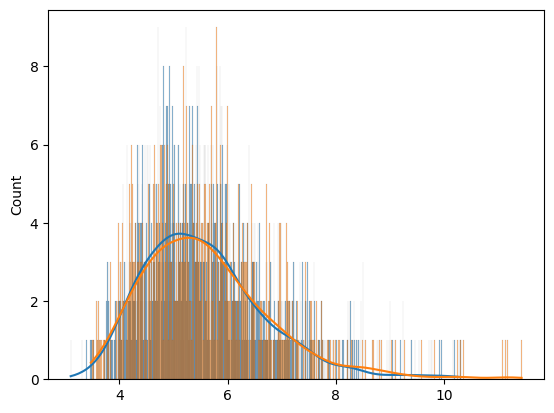

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import math

def draw(rng, n_samples=1000):
  """
  Draws a KDE plot of the distribution of a random number generator.

  Args:
    rng: A Python function that returns a random number.
    n_samples: The number of samples to draw from the RNG.

  Returns:
    None.
  """
  samples = np.array([rng() for _ in range(n_samples)])
  sns.histplot(samples, kde=True, binwidth=0.01)

# Define some example RNG functions
def orig():
    return max([random.normalvariate() for _ in range(1)])
    # if random.randint(0, 1) == 0:
    #     return max([random.normalvariate(1) for _ in range(1)])
    # else:
    #     return min([random.normalvariate(-1) for _ in range(1)])
    
class rng():
    def __init__(self, orig) -> None:
        self.orig = orig
        pass
    
    def __call__(self):
        choice = random.randint(0, 0)
        if choice == 0:
            return max([orig() * random.normalvariate() for _ in range(1000)])
        elif choice == 1:
            return min([orig() * random.normalvariate() for _ in range(1000)])

# draw(orig)
draw(rng(orig))
# draw(rng(rng(orig)))
draw(rng(rng(rng(rng(rng(rng(rng(rng(orig)))))))))
plt.show()